<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/final/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

#!pip install torchsummary

import torch

In [0]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0

Uninstalling Pillow-5.4.1:
  Successfully uninstalled Pillow-5.4.1
    100% |████████████████████████████████| 2.0MB 13.1MB/s 


In [0]:
# Load train class
!wget -c https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py

import Train

--2019-01-07 05:45:30--  https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15527 (15K) [text/plain]
Saving to: ‘Train.py’

Train.py            100%[===================>]  15.16K  --.-KB/s    in 0.01s   

2019-01-07 05:45:30 (1.27 MB/s) - ‘Train.py’ saved [15527/15527]



In [0]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim
from collections import OrderedDict
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import os
import json
from PIL import Image
import Train

# Load a Pretrained Model

In [0]:
# load a pretrained model
model = models.resnet50(pretrained = True)
num_ftrs = model.fc.in_features
num_ftrs

2048

# Load previous model

In [0]:
# laod model
model_save_name = 'desnet201_97.pt'
path = F"/content/gdrive/My Drive/model/final/{model_save_name}" 
model.load_state_dict(torch.load(path))
#model, optimizer, scheduler = Train.load_checkpoint(path, model, lr=0.003)

# Build

In [0]:
# if model is not save then run this cell
# change classifier
fc = nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(2048, 1780)),
                #('fc2', nn.Linear(1780, 1780)),
                ('fc2', nn.Linear(1780, 1500)),
                ('fc3', nn.Linear(1500, 1024)),
                #('fc5', nn.Linear(1024, 1024)),
                ('fc4', nn.Linear(1024, 786)),
                ('fc5', nn.Linear(786, 500)),
                ('relu', nn.ReLU()),
                ("dropout",nn.Dropout(p=0.20)),
                ('fc6', nn.Linear(500, 102)),
                ('output', nn.LogSoftmax(dim=1))
                ]))
model.fc = fc
model.fc

Sequential(
  (fc1): Linear(in_features=2048, out_features=1780, bias=True)
  (fc2): Linear(in_features=1780, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=786, bias=True)
  (fc5): Linear(in_features=786, out_features=500, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
  (fc6): Linear(in_features=500, out_features=102, bias=True)
  (output): LogSoftmax()
)

# Prepare Data

In [0]:
# Load data
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

!unzip -qq flower_data.zip

print("Data loaded")

Data loaded


In [0]:
import Train

# create train and test loader
data_dir = 'flower_data'

from torchvision import datasets, transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ColorJitter(saturation=0.05,hue=0.5),
        transforms.RandomRotation(10),
        #transforms.Pad(10),
        transforms.RandomAffine(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# ceate data loader
train_loader, valid_loader, test_loader = Train.prepare_loader(data_dir,transform_train,transform_valid,test_transforms)

Train size:6552
Valid size:6552
Test size:818


# Train Model

In [0]:
import time
# Freeze the parameter
#model = Train.freeze_parameters(model)
for _, param in model.named_parameters():
  param.requires_grad = False
print("Parameter Freezed")
time.asctime()

Parameter Freezed


'Mon Jan  7 07:14:39 2019'

In [52]:
# Unfreeze the parameter
model = Train.unfreeze(model)
#for _, param in model.named_parameters():
#  param.requires_grad = True

print("Parameter unfreezed")

Parameter unfreezed


In [0]:
# 7freeze + 
total_epochs_count = 20+20

In [0]:
# unfreeze the last layer
for pram in model.fc.parameters():
   pram.requires_grad = True
    
print("Last layer Unfreeze")
time.asctime()

Last layer Unfreeze


'Mon Jan  7 07:14:44 2019'

In [0]:
#unloock layer 2 and 3
for pram in model.layer2.parameters():
   pram.requires_grad = True
    
print("Last layer Unfreeze")
time.asctime()

Last layer Unfreeze


'Mon Jan  7 08:22:20 2019'

In [0]:
#unloock layer 2 and 3
for pram in model.layer3.parameters():
   pram.requires_grad = True
    
print("Last layer Unfreeze")
time.asctime()

Last layer Unfreeze


'Mon Jan  7 08:22:33 2019'

In [0]:
# if model is not save then run this cell
# set cretrion and optimizer
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.003,momentum=0.9)

#optimizer = optim.Adadelta(model.fc.parameters(),lr=0.003)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [0]:
#move tensor to default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [64]:
optimizer.state_dict

<bound method Optimizer.state_dict of SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.003
    lr: 0.00030000000000000003
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)>

In [75]:
# Train model
epochs = 10
model, train_loss,valid_loss = train_model(
    model,train_loader,valid_loader, epochs, optimizer,scheduler, criterion)

Epoch: 1/10
		Going for validation
	Train loss:0.078934.. 	Valid Loss:0.022719.. 	Accuracy: 97.1756
	Validation loss decreased (inf --> 0.022719).  Saving model ...
	Epoch:1 completed in 4m 38s
Epoch: 2/10
		Going for validation
	Train loss:0.080560.. 	Valid Loss:0.022626.. 	Accuracy: 96.7176
	Validation loss decreased (0.022719 --> 0.022626).  Saving model ...
	Epoch:2 completed in 4m 40s
Epoch: 3/10
		Going for validation
	Train loss:0.073256.. 	Valid Loss:0.023813.. 	Accuracy: 97.0229
	Epoch:3 completed in 4m 39s
Epoch: 4/10
		Going for validation
	Train loss:0.053691.. 	Valid Loss:0.023489.. 	Accuracy: 97.2519
	Epoch:4 completed in 4m 39s
Epoch: 5/10
		Going for validation
	Train loss:0.047810.. 	Valid Loss:0.023057.. 	Accuracy: 97.0229
	Epoch:5 completed in 4m 39s
Epoch: 6/10
		Going for validation
	Train loss:0.131711.. 	Valid Loss:0.022213.. 	Accuracy: 97.0229
	Validation loss decreased (0.022626 --> 0.022213).  Saving model ...
	Epoch:6 completed in 4m 40s
Epoch: 7/10
		Going f

In [0]:
mean = [0.4305, 0.3757, 0.2835]
std = [0.2942, 0.2424, 0.2675]

# Load model

In [0]:
# Load best model
name = "model.pt"
model.load_state_dict(torch.load(name))

In [0]:
#save model for further use
torch.save(model.state_dict(),"model97freeze2p.pt")

# Testing

In [0]:
train_data, valid_data = [],[]

In [0]:
#save test_data
for i in train_loss:
  train_data.append(i)
  
# valid
for i in valid_loss:
  valid_data.append(i)

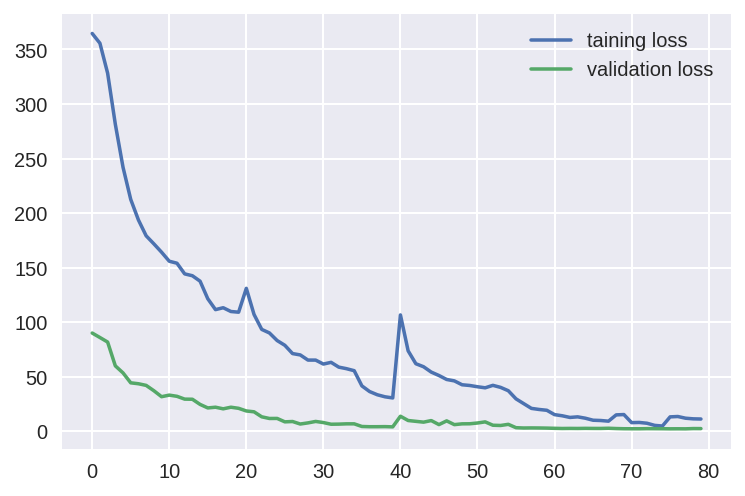

In [83]:
#Check for overfitting
plt.plot(train_data, label = "taining loss")
plt.plot(valid_data, label = "validation loss")
plt.legend(frameon = False)

In [0]:
#criterion = nn.CrossEntropyLoss()
# Test accuracy top 10 classs
Train.calculate_top_accuracy(model, test_loader, criterion,size=10)

Test Loss: 0.010965

Test Accuracy of     0: 100% ( 3/ 3)
Test Accuracy of     1: 100% ( 2/ 2)
Test Accuracy of     2: 100% ( 4/ 4)
Test Accuracy of     3: 100% ( 5/ 5)
Test Accuracy of     4: 100% ( 3/ 3)
Test Accuracy of     5: 50% ( 2/ 4)
Test Accuracy of     6: 100% ( 2/ 2)
Test Accuracy of     7: 66% ( 2/ 3)
Test Accuracy of     8: 100% ( 1/ 1)
Test Accuracy of     9: 100% ( 6/ 6)

Test Accuracy (Overall): 94% (389/410)


In [84]:
# Test total accuracy
Train.calc_accuracy(model,testset_path="flower_data/valid",batch_size=64)

Batch accuracy (Size 64): 0.96875
Batch accuracy (Size 64): 0.984375
Batch accuracy (Size 64): 0.96875
Batch accuracy (Size 64): 0.984375
Batch accuracy (Size 64): 0.984375
Batch accuracy (Size 64): 0.953125
Batch accuracy (Size 64): 0.984375
Batch accuracy (Size 64): 0.96875
Batch accuracy (Size 64): 0.921875
Batch accuracy (Size 64): 0.984375
Batch accuracy (Size 64): 0.96875
Batch accuracy (Size 64): 0.921875
Batch accuracy (Size 64): 0.9599999785423279
Mean accuracy: 0.9656730890274048


0.9656731

In [0]:
# Test with google data set
Train.calc_accuracy(model,use_google_testset=True,batch_size=batch_size)

# Save checkpoint

In [0]:
#save model
name = "model1_19_97.pt"
Train.save_check_point(model, optimizer, scheduler, train_loader, name, 7, save_cpu=False)

Model saved at model1_19_97.pt


In [0]:
#load model again
model, optimizer, scheduler = Train.load_checkpoint(name, model)

26,971,084 total parameters.
8,878,156 total gradient parameters.
Model has been trained for 7 epochs.


# Image Preprocessing

In [0]:
#Time for visalize
cat_to_name = Train.get_cat_name()
class_to_idx = train_loader.dataset.class_to_idx
idx_to_name = {idx: cat_to_name[category] for category, idx in train_loader.dataset.class_to_idx.items()}
list(idx_to_name.items())[:6]
list(cat_to_name.keys())[:6]

['21', '3', '45', '1', '34', '27']

In [0]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a PyTorch tensor
    '''
    
    image = Image.open(image_path)
    
    # Resize
    img = image.resize((256, 256))
    
    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    img = img.crop((left, top, right, bottom))
    
    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256
    
    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)
    
    return img_tensor

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image); plt.axis('off')
    
    return ax, image

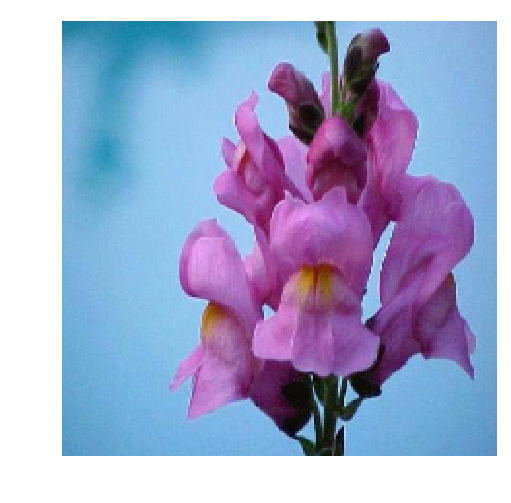

In [0]:
img = process_image('flower_data/valid/11/image_03125.jpg')
ax, image = imshow(img)

# Class Prediction

In [0]:
def random_image_path():
    """Generate a random image path from validation set"""
    cat = np.random.choice(os.listdir(f'flower_data/valid/'))
    image_filename = np.random.choice(os.listdir(f'flower_data/valid/{cat}/'))
    ex_path = f'flower_data/valid/{cat}/' + image_filename
    print(f"Path:{ex_path}")
    return ex_path

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    real_class = model.cat_to_name[image_path.split('/')[2]]
    img_tensor = process_image(image_path)
    
    if torch.cuda.is_available():
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Output is not a probability or a log probability
        out = model(img_tensor)
        
        # Apply softmax across classes
        ps = torch.softmax(out, dim = 1)
        
        topk, topclass = ps.topk(topk, dim = 1)
        top_classes = [model.idx_to_name[class_] for class_ in topclass.cpu().numpy()[0]]
        top_ps = topk.cpu().numpy()[0]
        return top_ps, top_classes, real_class, img_tensor.cpu().squeeze()

In [0]:
ex_path = random_image_path()
ps, classes, y_obs, img = predict(ex_path, model)

Path:flower_data/valid/54/image_05417.jpg


(array([9.9999726e-01, 1.1589552e-06, 6.9063231e-07, 2.3952825e-07,
        2.3180276e-07], dtype=float32),
 ['sunflower', 'tiger lily', 'barbeton daisy', 'gazania', 'artichoke'])

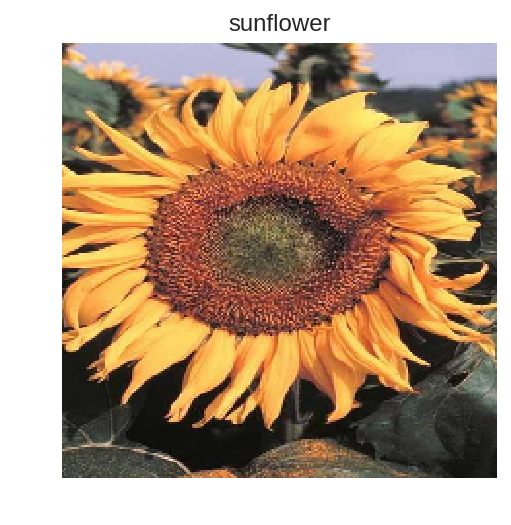

In [0]:
ax, img = imshow(img);
ax.set_title(y_obs);
ps, classes

# Sanity Checking



In [0]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""
    # Get predictions
    real_cat = image_path.split('/')[2]
    n_train_images = len(os.listdir(f'flower_data/train/{real_cat}'))
    
    ps, classes, y_obs, img = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index = classes)
    
    plt.figure(figsize = (6, 5))
    ax = plt.subplot(1, 1, 1)
    ax, img = imshow(img, ax = ax);
    ax.set_title(y_obs, size = 20);
    plt.show();
    
    result.sort_values('p')['p'].plot.barh(color = 'blue', edgecolor = 'k');
    plt.xlabel('Predicted Probability'); plt.ylabel('Classes');
    plt.show();
    
    print(f'{n_train_images} training images for {y_obs}.')

Path:flower_data/valid/101/image_07985.jpg


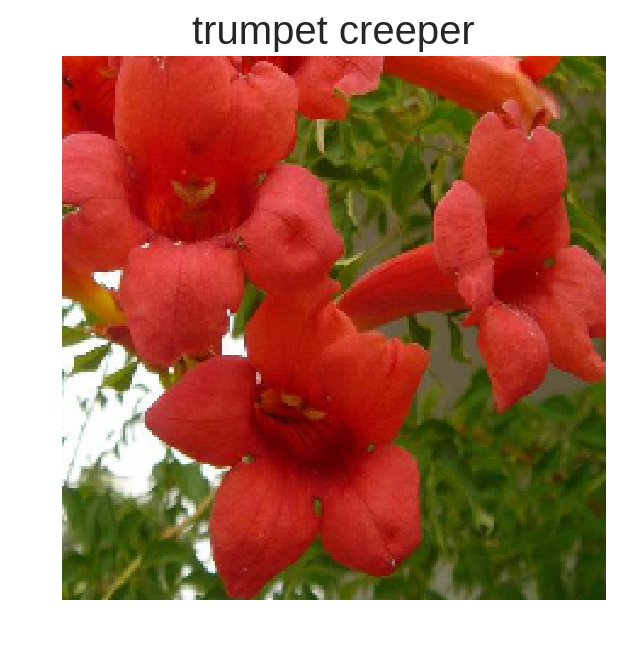

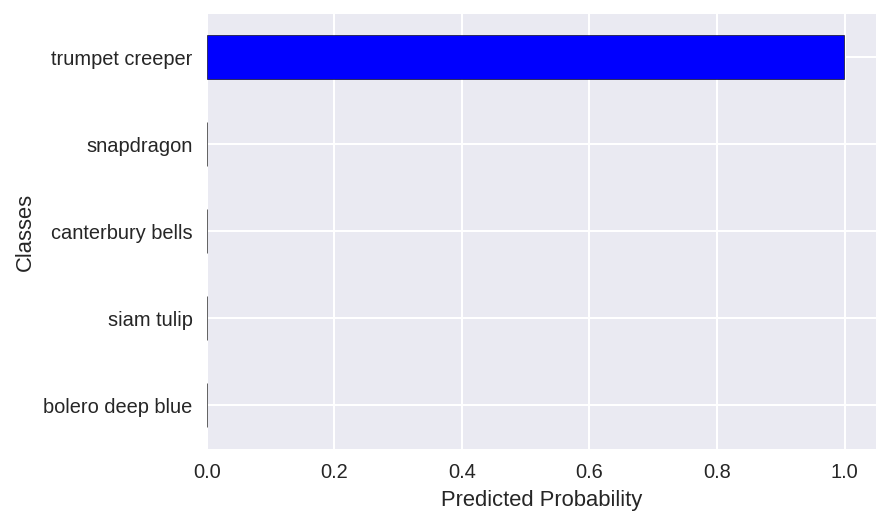

49 training images for trumpet creeper.


In [0]:
import pandas as pd
ex_path = random_image_path()
display_prediction(ex_path, model, 5)

# Save on Google Drive
Save to the google drive for latter use

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model_save_name = 'resnet50_96.75_unfreeze.pt'
path = F"/content/gdrive/My Drive/model/{model_save_name}"
torch.save(model.state_dict(), path)

In [0]:
#Save checkpoint
model_save_name = 'desnet201_61_unfreeze.pt'
path = F"/content/gdrive/My Drive/model/final/{model_save_name}"
Train.save_check_point(model, optimizer, scheduler, train_loader, path, 7, save_cpu=False)

Model saved at /content/gdrive/My Drive/model/final/desnet201_61_unfreeze.pt


# Load to udacity workspace

In [0]:
my_file_id = "1HPuJ4U2rjz95UdZ2N8496jTiZQ5O3pg1"
!gdown https://drive.google.com/uc?id={my_file_id}

#tensorboard


In [69]:
!pip install tensorboardx

    100% |████████████████████████████████| 133kB 3.7MB/s 


In [70]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = 'log'  # '"./drive/My Drive/log/"' for Drive location
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

import time
time.sleep(2)

get_ipython().system_raw('ngrok http 6006 &')

time.sleep(2)

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-01-07 15:08:21--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.4.75.11, 52.45.111.123, 52.44.92.122, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.4.75.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  3.47MB/s    in 1.5s    

2019-01-07 15:08:23 (3.47 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/deco

In [0]:
from tensorboardX import SummaryWriter

def train_model(model,
                train_loader,
                valid_loader,
                n_epochs,
                optimizer,
                scheduler,
                criterion,
                name="model.pt",
                path=None):
    # compare overfited
    train_loss_data, valid_loss_data = [], []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()
    #summery writer
    writer = SummaryWriter(log_dir='log/runs/test-1')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(n_epochs):
        print("Epoch: {}/{}".format(epoch + 1, n_epochs))
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        correct = 0
        e_since = time.time()

        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        scheduler.step()  # step up scheduler
        for images, labels in train_loader:
            # Move input and label tensors to the default device
            images, labels = images.to(device), labels.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            log_ps = model(images)
            # calculate the loss
            loss = criterion(log_ps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * images.size(0)
            
        #write with writer
        writer.add_scalar('data/batch_loss', loss.item(), epoch)  

        ######################
        # validate the model #
        ######################
        print("\t\tGoing for validation")
        model.eval()  # prep model for evaluation
        for data, target in valid_loader:
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss_p = criterion(output, target)
            # update running validation loss
            valid_loss += loss_p.item() * data.size(0)
            # calculate accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        # calculate train loss and running loss
        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)

        print("\tTrain loss:{:.6f}..".format(train_loss),
              "\tValid Loss:{:.6f}..".format(valid_loss),
              "\tAccuracy: {:.4f}".format(correct / total * 100))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), name)
            valid_loss_min = valid_loss
            # save to google drive
            if path is not None:
                torch.save(model.state_dict(), path)

        # Time take for one epoch
        time_elapsed = time.time() - e_since
        print('\tEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    # compare total time
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # return the model
    return [model, train_loss_data, valid_loss_data]

In [0]:
def calculate_top_accuracy(model, test_loader, criterion, data_dir="flower_data", size=10):
    classes = os.listdir("{}/valid".format(data_dir))
    test_loss = 0
    class_correct = list(0. for i in range(102))
    class_total = list(0. for i in range(102))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        model.eval()  # prep model for evaluation
        for data, target in test_loader:
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update test loss
            test_loss += loss.item()  # *data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)
            # compare predictions to true label
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            # calculate test accuracy for each object class
            for i in range(size):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

        # calculate and print avg test loss
        test_loss = test_loss / len(test_loader.dataset)
        print('Test Loss: {:.6f}\n'.format(test_loss))

        for i in range(size):
            if class_total[i] > 0:
                print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                    str(i), 100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
            100. * np.sum(class_correct) / np.sum(class_total),
            np.sum(class_correct), np.sum(class_total)))

SyntaxError: ignored

In [0]:
python -m tensorboard.main